## **Conformal Prediction using Energy Hospital Load**

One example of the NP data is the electricity consumption of a hospital in SF. It has hourly reservation for the entire year of 2015.

### Library Setup
Requires Python 3.9+

In [1]:
!python --version

Python 3.9.12


Install from scratch

In [2]:
# !git clone https://github.com/ourownstory/neural_prophet.git
# !cd neural_prophet
# !pip install -e ".[dev]"

### Extract Data and Split Data into Train, Val, Cal, and Test


**Extract Data From GitHub**

In [3]:
import numpy as np
import pandas as pd
from neuralprophet import NeuralProphet, set_log_level, set_random_seed

In [4]:
data_location = "https://raw.githubusercontent.com/ourownstory/neuralprophet-data/main/datasets/"
file = "energy/SF_hospital_load.csv"

In [5]:
data_df = pd.read_csv(data_location + file)

In [6]:
data_df.head(5)

,ds,y
0,2015-01-01 01:00:00,778.007969
1,2015-01-01 02:00:00,776.241750
2,2015-01-01 03:00:00,779.357338
3,2015-01-01 04:00:00,778.737196
4,2015-01-01 05:00:00,787.835835


In [7]:
data_df.tail(5)

,ds,y
8755,2015-12-31 20:00:00,845.563081
8756,2015-12-31 21:00:00,827.530521
8757,2015-12-31 22:00:00,829.256300
8758,2015-12-31 23:00:00,813.937205
8759,2016-01-01 00:00:00,815.588584


**Split data into train, val, cal, and test in that order**

Do we need to instantiate a NP model `m` in order to split the df into train and test? If so, does the NP params make any diff to the outcome of this split? I'm presuming no atm.

In [8]:
m = NeuralProphet()

In [9]:
train_df, test_df = m.split_df(data_df, freq="H", valid_p=1.0 / 16)
train_df, cal_df = m.split_df(train_df, freq="H", valid_p=1.0 / 11)
train_df, val_df = m.split_df(train_df, freq="H", valid_p=1.0 / 10)

INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.989% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.988% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.987% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_

In [10]:
train_df.shape, val_df.shape, cal_df.shape, test_df.shape

((6721, 2), (746, 2), (746, 2), (547, 2))

In [11]:
print(f"Train set time range:        {train_df['ds'].min()} - {train_df['ds'].max()}")
print(f"Validation set time range:   {val_df['ds'].min()} - {val_df['ds'].max()}")
print(f"Calibration set time range:  {cal_df['ds'].min()} - {cal_df['ds'].max()}")
print(f"Test set time range:         {test_df['ds'].min()} - {test_df['ds'].max()}")

Train set time range:        2015-01-01 01:00:00 - 2015-10-08 01:00:00
Validation set time range:   2015-10-08 02:00:00 - 2015-11-08 03:00:00
Calibration set time range:  2015-11-08 04:00:00 - 2015-12-09 05:00:00
Test set time range:         2015-12-09 06:00:00 - 2016-01-01 00:00:00


**Plot train_df**

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [13]:
x_size = 16
y_size = 6
figsize = (x_size, y_size)

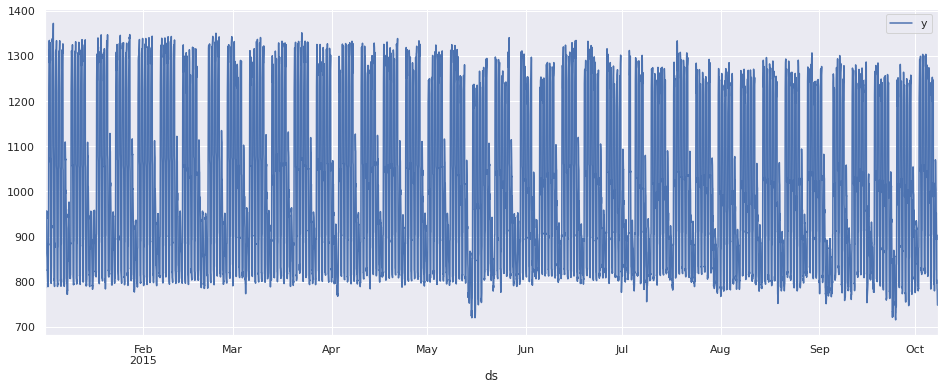

In [14]:
train_df.set_index("ds").plot(figsize=figsize);

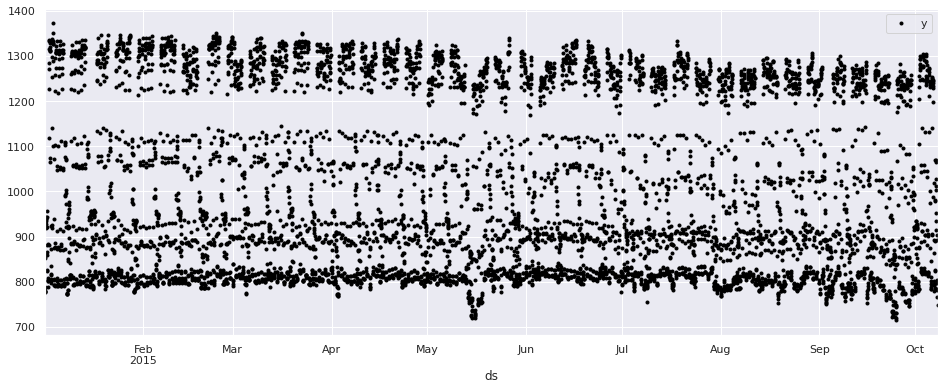

In [15]:
train_df.set_index("ds").plot(marker=".", linestyle="none", colormap="gray", figsize=figsize);

### Train the NP Models (with 5th/95th Quantiles)
- `m1`: NP with default features
- `m2`: NP with parametric time-based features (like in Facebook Prophet)
- `m3`: NP with 1-layer AR
- `m4`: NP with 4-layer deep AR

In [16]:
quantile_lo, quantile_hi = 0.05, 0.95
quantiles = [quantile_lo, quantile_hi]
n_lags = 3 * 24

In [17]:
m1 = NeuralProphet(
    quantiles=quantiles,
)
m2 = NeuralProphet(
    weekly_seasonality=6,
    daily_seasonality=10,
    trend_reg=1,
    learning_rate=0.01,
    quantiles=quantiles,
)
m3 = NeuralProphet(
    growth="off",
    yearly_seasonality=False,
    weekly_seasonality=False,
    daily_seasonality=False,
    n_lags=n_lags,
    ar_reg=1,
    learning_rate=0.01,
    quantiles=quantiles,
)
m4 = NeuralProphet(
    growth="off",
    yearly_seasonality=False,
    weekly_seasonality=False,
    daily_seasonality=False,
    n_lags=n_lags,
    num_hidden_layers=4,
    d_hidden=32,
    learning_rate=0.003,
    quantiles=quantiles,
)

INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.


Train the 4 models. You can either concatonate the train and val set into one full training set or use the val set separately for hyperparameter tuning. I recommend trying both ways to see how to performance evaluation metrics change.

In [18]:
%%time
random_seed = 0

# Conconate train_df and val_df as full training set
set_random_seed(random_seed)
metrics1 = m1.fit(pd.concat([train_df, val_df]), freq="H")
set_random_seed(random_seed)
metrics2 = m2.fit(pd.concat([train_df, val_df]), freq="H")
set_random_seed(random_seed)
metrics3 = m3.fit(pd.concat([train_df, val_df]), freq="H")
set_random_seed(random_seed)
metrics4 = m4.fit(pd.concat([train_df, val_df]), freq="H")

# Use val_df for validation
# set_random_seed(random_seed)
# metrics1 = m1.fit(train_df, freq='H', validation_df=val_df)
# set_random_seed(random_seed)
# metrics2 = m2.fit(train_df, freq='H', validation_df=val_df)
# set_random_seed(random_seed)
# metrics3 = m3.fit(train_df, freq='H', validation_df=val_df)
# set_random_seed(random_seed)
# metrics4 = m4.fit(train_df, freq='H', validation_df=val_df)
# metrics4 = m4.fit(train_df, freq='H', validation_df=val_df, progress='plot')

INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.987% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 111
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (234) is too small than the required number for the learning rate finder (246). The results might not be optimal.
WARNING - (py.warnings._showwarnmsg) - /home/studio-lab-user/.conda/envs/dev/lib/p

Finding best initial lr:   0%|          | 0/246 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=246` reached.
Restoring states from the checkpoint path at /home/studio-lab-user/sagemaker-studiolab-notebooks/workspace/neuralprophet/neural_prophet_kevin/tutorials/feature-use/.lr_find_b7cab759-e89c-4de5-85d0-cd2fcf18a5a1.ckpt
Loading `train_dataloader` to estimate number of stepping batches.

  | Name          | Type             | Params
---------------------------------------------------
0 | metrics_train | MetricCollection | 0     
1 | metrics_val   | MetricCollection | 0     
2 | season_params | ParameterDict    | 54    
---------------------------------------------------
93        Trainable params
0         Non-trainable params
93        Total params
0.000     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=111` reached.
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.987% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 111
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (234) is too small than the required number for the learning rate finder (246). The results might not be optimal.
WARNING - (py.warnings._showwarnm

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=111` reached.
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.987% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 111
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (232) is too small than the required number for the learning rate finder (246). The results might not be optimal.
WARNING - (py.warnings._showwarnmsg) - /home/studio-lab-user/.conda/envs/dev/lib/python3.9/site-packages/pytorch_lightning/trainer/configuration_validator.py:117: Possible

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=111` reached.
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.987% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 111
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (232) is too small than the required number for the learning rate finder (246). The results might not be optimal.
WARNING - (py.warnings._showwarnmsg) - /home/studio-lab-user/.conda/envs/dev/lib/python3.9/site-packages/pytorch_lightning/trainer/configuration_validator.py:117: Possible

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=111` reached.


CPU times: user 9min, sys: 2.22 s, total: 9min 2s
Wall time: 9min 39s


In [19]:
metrics1.tail(1)

,MAE,RMSE,Loss,RegLoss,epoch
110,64.864601,80.605118,0.008875,0.0,110


In [20]:
metrics2.tail(1)

,MAE,RMSE,Loss,RegLoss,epoch
110,45.093803,62.327168,0.009799,0.00406,110


In [21]:
metrics3.tail(1)

,MAE,RMSE,Loss,RegLoss,epoch
110,23.764839,35.071205,0.003226,0.001175,110


In [22]:
metrics4.tail(1)

,MAE,RMSE,Loss,RegLoss,epoch
110,7.063153,10.06792,0.000155,0.0,110


**Get forecasts of out-of-sample (OOS) test_df**

In [23]:
forecast1 = m1.predict(test_df)[n_lags:]
forecast2 = m2.predict(test_df)[n_lags:]
forecast3 = m3.predict(test_df)[n_lags:]
forecast4 = m4.predict(test_df)[n_lags:]

INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.817% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.817% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
WARNING - (py.warnings._showwarnmsg) - /home/studio-lab-user/.conda/envs/dev/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:225: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(



Predicting: 234it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.817% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.817% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
WARNING - (py.warnings._showwarnmsg) - /home/studio-lab-user/.conda/envs/dev/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:225: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(



Predicting: 234it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.817% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.818% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
WARNING - (py.warnings._showwarnmsg) - /home/studio-lab-user/.conda/envs/dev/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:225: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(



Predicting: 232it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.817% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.818% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
WARNING - (py.warnings._showwarnmsg) - /home/studio-lab-user/.conda/envs/dev/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:225: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(



Predicting: 232it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


In [24]:
forecast1.head()

,ds,y,yhat1,yhat1 5.0%,yhat1 95.0%,trend,season_weekly,season_daily
72,2015-12-12 06:00:00,879.551547,1087.088623,972.237061,1165.704346,1032.707031,61.734299,-7.352807
73,2015-12-12 07:00:00,1102.066076,1194.688843,1066.541138,1272.411499,1032.724121,60.781769,101.183006
74,2015-12-12 08:00:00,1214.971839,1259.173584,1139.253418,1323.115479,1032.741089,59.720352,166.712158
75,2015-12-12 09:00:00,1257.597327,1274.854980,1169.967651,1333.975098,1032.758057,58.582054,183.514786
76,2015-12-12 10:00:00,1293.807143,1272.488403,1175.265137,1331.768677,1032.775146,57.397614,182.315750


In [25]:
forecast2.head()

,ds,y,yhat1,yhat1 5.0%,yhat1 95.0%,trend,season_weekly,season_daily
72,2015-12-12 06:00:00,879.551547,1058.354004,886.055664,1114.938843,992.848877,70.711014,-5.205965
73,2015-12-12 07:00:00,1102.066076,1188.042480,1030.611572,1230.603027,992.843506,77.486610,117.712303
74,2015-12-12 08:00:00,1214.971839,1223.014893,1083.285400,1263.936523,992.838135,82.590950,147.585846
75,2015-12-12 09:00:00,1257.597327,1265.865845,1106.003418,1297.716553,992.832764,85.812485,187.220642
76,2015-12-12 10:00:00,1293.807143,1268.428955,1108.512695,1297.833252,992.827393,87.046600,188.554977


In [26]:
forecast3.head()

,ds,y,yhat1,yhat1 5.0%,yhat1 95.0%,ar1,trend
72,2015-12-12 06:00:00,879.551547,875.405640,834.498840,918.954468,128.263489,747.142151
73,2015-12-12 07:00:00,1102.066076,1072.964355,1032.056885,1116.513428,325.822174,747.142151
74,2015-12-12 08:00:00,1214.971839,1175.438721,1134.531006,1218.987793,428.296631,747.142151
75,2015-12-12 09:00:00,1257.597327,1277.692627,1236.784302,1321.241333,530.550537,747.142151
76,2015-12-12 10:00:00,1293.807143,1311.674316,1270.765747,1355.221924,564.532104,747.142151


In [27]:
forecast4.head()

,ds,y,yhat1,yhat1 5.0%,yhat1 95.0%,ar1,trend
72,2015-12-12 06:00:00,879.551547,883.944336,876.346191,888.811707,-63.687786,947.632141
73,2015-12-12 07:00:00,1102.066076,1111.180298,1092.691528,1122.760010,163.548203,947.632141
74,2015-12-12 08:00:00,1214.971839,1228.296753,1217.268921,1241.771606,280.664581,947.632141
75,2015-12-12 09:00:00,1257.597327,1265.819092,1254.519043,1274.899170,318.187012,947.632141
76,2015-12-12 10:00:00,1293.807143,1297.054810,1285.453125,1308.629150,349.422699,947.632141


**Plot QR forecasts with OOS test_df**

In [28]:
cutoff = 7 * 24  # 0
x_size = 10
y_size = 5
figsize = (x_size, y_size)
plotting_backend = "default"

WARNING - (NP.forecaster.plot) - highlight_forecast_step_n is ignored since auto-regression not enabled.
WARNING - (NP.forecaster.plot) - highlight_forecast_step_n is ignored since auto-regression not enabled.


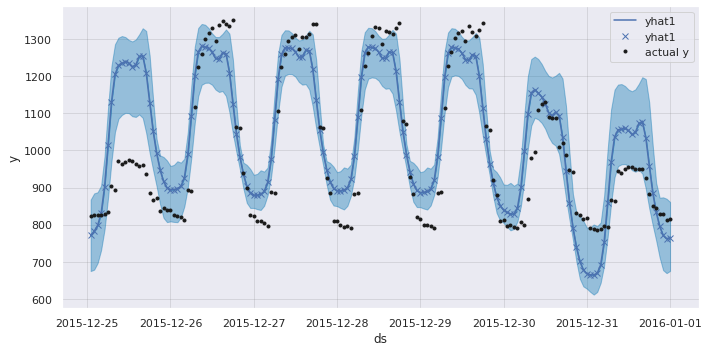

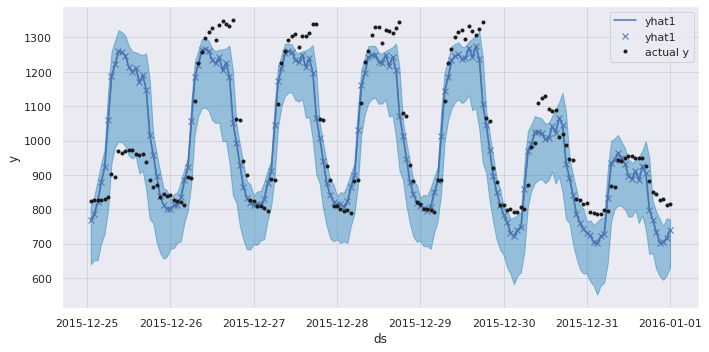

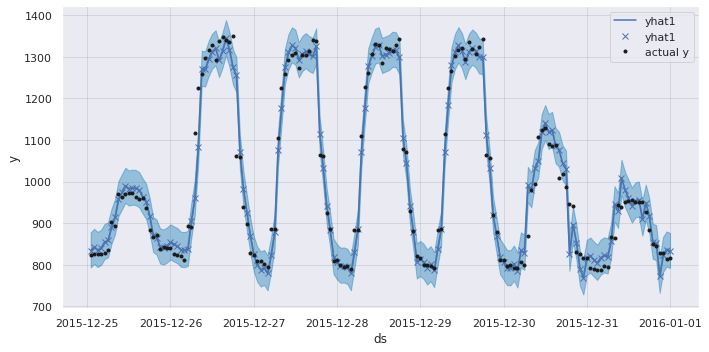

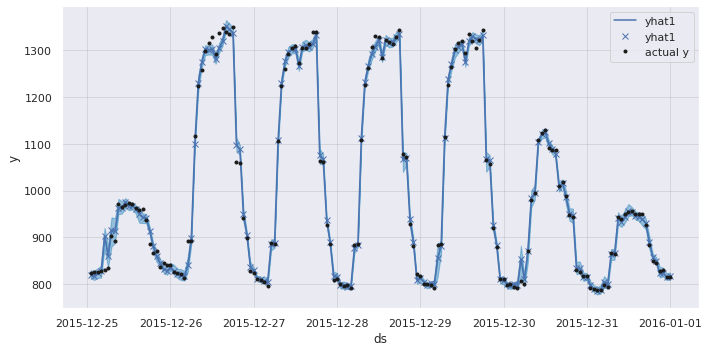

In [29]:
fig1 = m1.highlight_nth_step_ahead_of_each_forecast(1).plot(
    forecast1[-cutoff:], figsize=figsize, plotting_backend=plotting_backend
)
fig2 = m2.highlight_nth_step_ahead_of_each_forecast(1).plot(
    forecast2[-cutoff:], figsize=figsize, plotting_backend=plotting_backend
)
fig3 = m3.highlight_nth_step_ahead_of_each_forecast(1).plot(
    forecast3[-cutoff:], figsize=figsize, plotting_backend=plotting_backend
)
fig4 = m4.highlight_nth_step_ahead_of_each_forecast(1).plot(
    forecast4[-cutoff:], figsize=figsize, plotting_backend=plotting_backend
)

### Conformalize and plot

In [30]:
alpha = 0.1

**Naive**

INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.866% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.866% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
WARNING - (py.warnings._showwarnmsg) - /home/studio-lab-user/.conda/envs/dev/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:225: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(



Predicting: 234it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.866% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.866% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
WARNING - (py.warnings._showwarnmsg) - /home/studio-lab-user/.conda/envs/dev/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:225: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(



Predicting: 234it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.866% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.866% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
WARNING - (py.warnings._showwarnmsg) - /home/studio-lab-user/.conda/envs/dev/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:225: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(



Predicting: 232it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.866% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.866% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
WARNING - (py.warnings._showwarnmsg) - /home/studio-lab-user/.conda/envs/dev/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:225: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(



Predicting: 232it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


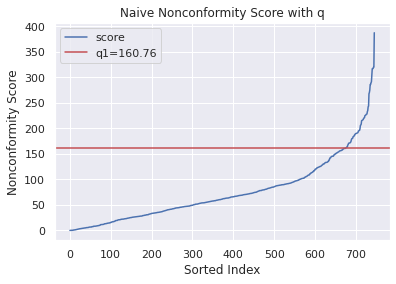

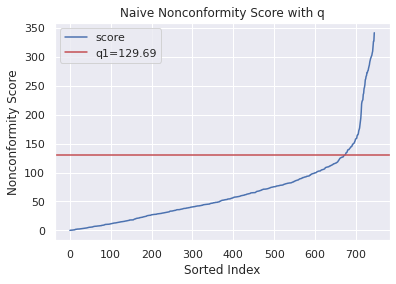

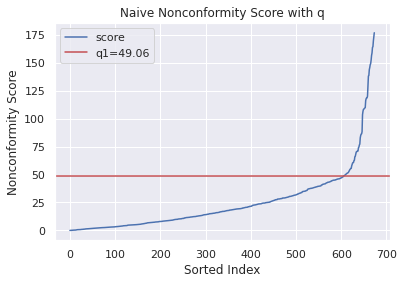

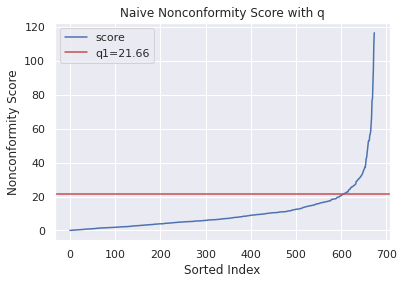

In [31]:
method = "naive"
m1.conformalize(cal_df, alpha=alpha, method=method)
m2.conformalize(cal_df, alpha=alpha, method=method)
m3.conformalize(cal_df, alpha=alpha, method=method)
m4.conformalize(cal_df, alpha=alpha, method=method)

In [32]:
naive_qhat1, naive_qhat2, naive_qhat3, naive_qhat4 = m1.q_hats[0], m2.q_hats[0], m3.q_hats[0], m4.q_hats[0]
naive_qhat1, naive_qhat2, naive_qhat3, naive_qhat4

(160.75530026875003, 129.69230146250004, 49.055130528125005, 21.65865092343745)

Get forecasts and *naive* conformal prediction interval of OOS test_df

In [33]:
naive_forecast1 = m1.predict(test_df)[n_lags:]
naive_forecast2 = m2.predict(test_df)[n_lags:]
naive_forecast3 = m3.predict(test_df)[n_lags:]
naive_forecast4 = m4.predict(test_df)[n_lags:]

INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.817% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.817% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
WARNING - (py.warnings._showwarnmsg) - /home/studio-lab-user/.conda/envs/dev/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:225: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(



Predicting: 234it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.817% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.817% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
WARNING - (py.warnings._showwarnmsg) - /home/studio-lab-user/.conda/envs/dev/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:225: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(



Predicting: 234it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.817% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.818% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
WARNING - (py.warnings._showwarnmsg) - /home/studio-lab-user/.conda/envs/dev/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:225: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(



Predicting: 232it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.817% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.818% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
WARNING - (py.warnings._showwarnmsg) - /home/studio-lab-user/.conda/envs/dev/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:225: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(



Predicting: 232it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


In [34]:
# method='naive'
# naive_forecast1 = m1.conformalize_predict(test_df, df_cal=cal_df, alpha=alpha, method=method)
# naive_forecast2 = m2.conformalize_predict(test_df, df_cal=cal_df, alpha=alpha, method=method)
# naive_forecast3 = m3.conformalize_predict(test_df, df_cal=cal_df, alpha=alpha, method=method)
# naive_forecast4 = m4.conformalize_predict(test_df, df_cal=cal_df, alpha=alpha, method=method)

In [35]:
naive_forecast1.head()

,ds,y,yhat1,yhat1 5.0%,yhat1 95.0%,trend,season_weekly,season_daily,yhat1 - qhat1,yhat1 + qhat1
72,2015-12-12 06:00:00,879.551547,1087.088623,972.237061,1165.704346,1032.707031,61.734299,-7.352807,926.333323,1247.843923
73,2015-12-12 07:00:00,1102.066076,1194.688843,1066.541138,1272.411499,1032.724121,60.781769,101.183006,1033.933543,1355.444143
74,2015-12-12 08:00:00,1214.971839,1259.173584,1139.253418,1323.115479,1032.741089,59.720352,166.712158,1098.418284,1419.928884
75,2015-12-12 09:00:00,1257.597327,1274.854980,1169.967651,1333.975098,1032.758057,58.582054,183.514786,1114.099680,1435.610281
76,2015-12-12 10:00:00,1293.807143,1272.488403,1175.265137,1331.768677,1032.775146,57.397614,182.315750,1111.733103,1433.243704


In [36]:
naive_forecast2.head()

,ds,y,yhat1,yhat1 5.0%,yhat1 95.0%,trend,season_weekly,season_daily,yhat1 - qhat1,yhat1 + qhat1
72,2015-12-12 06:00:00,879.551547,1058.354004,886.055664,1114.938843,992.848877,70.711014,-5.205965,928.661702,1188.046305
73,2015-12-12 07:00:00,1102.066076,1188.042480,1030.611572,1230.603027,992.843506,77.486610,117.712303,1058.350179,1317.734782
74,2015-12-12 08:00:00,1214.971839,1223.014893,1083.285400,1263.936523,992.838135,82.590950,147.585846,1093.322591,1352.707194
75,2015-12-12 09:00:00,1257.597327,1265.865845,1106.003418,1297.716553,992.832764,85.812485,187.220642,1136.173543,1395.558146
76,2015-12-12 10:00:00,1293.807143,1268.428955,1108.512695,1297.833252,992.827393,87.046600,188.554977,1138.736654,1398.121257


In [37]:
naive_forecast3.head()

,ds,y,yhat1,yhat1 5.0%,yhat1 95.0%,ar1,trend,yhat1 - qhat1,yhat1 + qhat1
72,2015-12-12 06:00:00,879.551547,875.405640,834.498840,918.954468,128.263489,747.142151,826.350509,924.460770
73,2015-12-12 07:00:00,1102.066076,1072.964355,1032.056885,1116.513428,325.822174,747.142151,1023.909225,1122.019486
74,2015-12-12 08:00:00,1214.971839,1175.438721,1134.531006,1218.987793,428.296631,747.142151,1126.383590,1224.493851
75,2015-12-12 09:00:00,1257.597327,1277.692627,1236.784302,1321.241333,530.550537,747.142151,1228.637496,1326.747757
76,2015-12-12 10:00:00,1293.807143,1311.674316,1270.765747,1355.221924,564.532104,747.142151,1262.619186,1360.729447


In [38]:
naive_forecast4.head()

,ds,y,yhat1,yhat1 5.0%,yhat1 95.0%,ar1,trend,yhat1 - qhat1,yhat1 + qhat1
72,2015-12-12 06:00:00,879.551547,883.944336,876.346191,888.811707,-63.687786,947.632141,862.285685,905.602987
73,2015-12-12 07:00:00,1102.066076,1111.180298,1092.691528,1122.760010,163.548203,947.632141,1089.521647,1132.838949
74,2015-12-12 08:00:00,1214.971839,1228.296753,1217.268921,1241.771606,280.664581,947.632141,1206.638102,1249.955404
75,2015-12-12 09:00:00,1257.597327,1265.819092,1254.519043,1274.899170,318.187012,947.632141,1244.160441,1287.477743
76,2015-12-12 10:00:00,1293.807143,1297.054810,1285.453125,1308.629150,349.422699,947.632141,1275.396159,1318.713460


Plot QR forecasts and *naive* conformal prediction intervals with OOS test_df

WARNING - (NP.forecaster.plot) - highlight_forecast_step_n is ignored since auto-regression not enabled.
WARNING - (NP.forecaster.plot) - highlight_forecast_step_n is ignored since auto-regression not enabled.


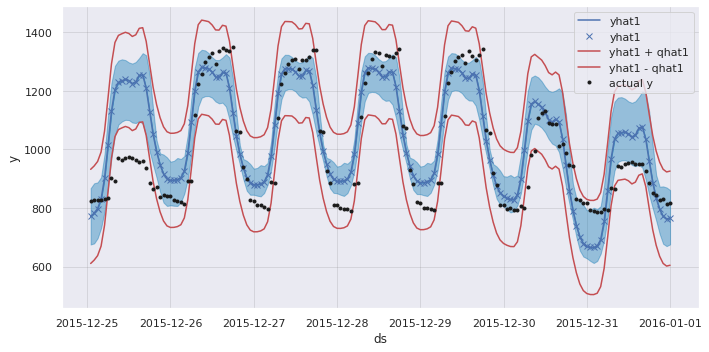

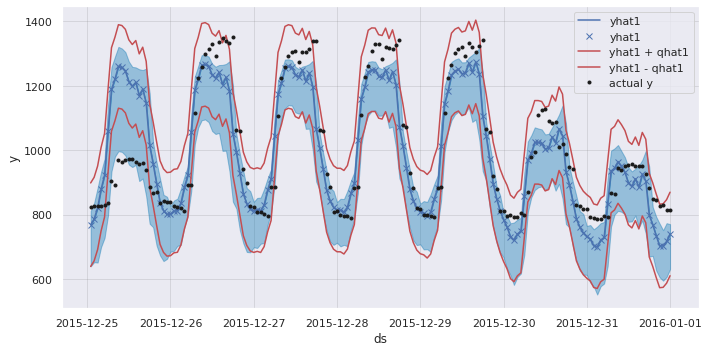

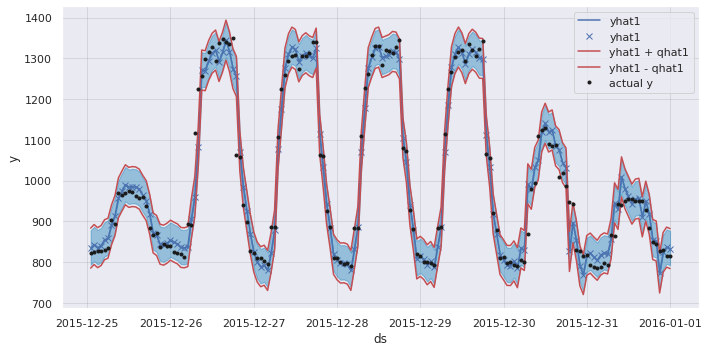

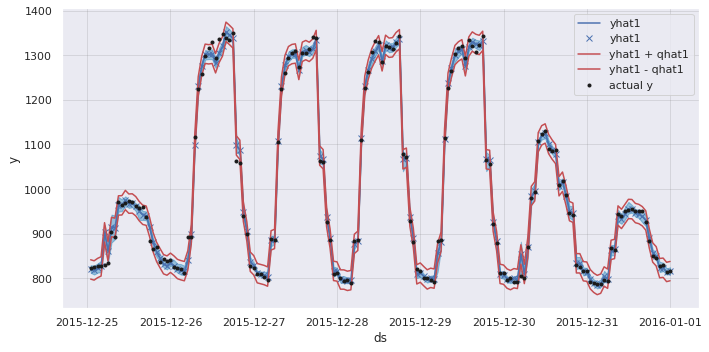

In [39]:
fig1 = m1.highlight_nth_step_ahead_of_each_forecast(1).plot(
    naive_forecast1[-cutoff:], figsize=figsize, plotting_backend=plotting_backend
)
fig2 = m2.highlight_nth_step_ahead_of_each_forecast(1).plot(
    naive_forecast2[-cutoff:], figsize=figsize, plotting_backend=plotting_backend
)
fig3 = m3.highlight_nth_step_ahead_of_each_forecast(1).plot(
    naive_forecast3[-cutoff:], figsize=figsize, plotting_backend=plotting_backend
)
fig4 = m4.highlight_nth_step_ahead_of_each_forecast(1).plot(
    naive_forecast4[-cutoff:], figsize=figsize, plotting_backend=plotting_backend
)

**CQR**

INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.866% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.866% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
WARNING - (py.warnings._showwarnmsg) - /home/studio-lab-user/.conda/envs/dev/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:225: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(



Predicting: 234it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.866% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.866% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
WARNING - (py.warnings._showwarnmsg) - /home/studio-lab-user/.conda/envs/dev/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:225: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(



Predicting: 234it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.866% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.866% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
WARNING - (py.warnings._showwarnmsg) - /home/studio-lab-user/.conda/envs/dev/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:225: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(



Predicting: 232it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.866% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.866% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
WARNING - (py.warnings._showwarnmsg) - /home/studio-lab-user/.conda/envs/dev/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:225: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(



Predicting: 232it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


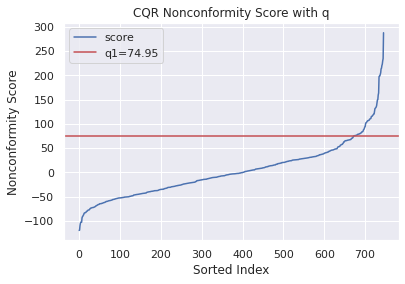

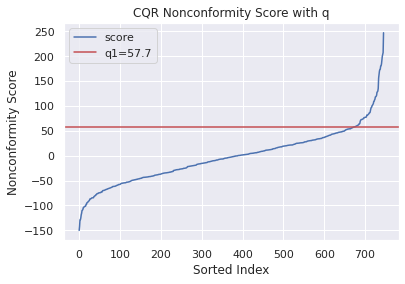

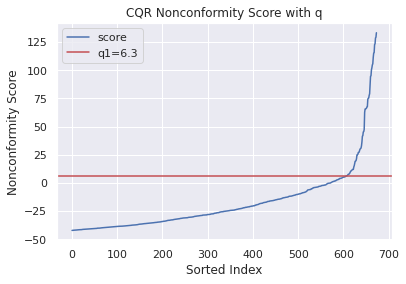

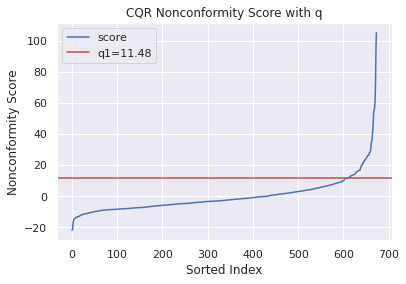

In [40]:
method = "cqr"
m1.conformalize(cal_df, alpha=alpha, method=method)
m2.conformalize(cal_df, alpha=alpha, method=method)
m3.conformalize(cal_df, alpha=alpha, method=method)
m4.conformalize(cal_df, alpha=alpha, method=method)

In [41]:
cqr_qhat1, cqr_qhat2, cqr_qhat3, cqr_qhat4 = m1.q_hats[0], m2.q_hats[0], m3.q_hats[0], m4.q_hats[0]
cqr_qhat1, cqr_qhat2, cqr_qhat3, cqr_qhat4

(74.94919968203124, 57.69908539453127, 6.295553921874898, 11.481231328906233)

Get forecasts and *CQR* conformal prediction interval of OOS test_df

In [42]:
cqr_forecast1 = m1.predict(test_df)[n_lags:]
cqr_forecast2 = m2.predict(test_df)[n_lags:]
cqr_forecast3 = m3.predict(test_df)[n_lags:]
cqr_forecast4 = m4.predict(test_df)[n_lags:]

INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.817% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.817% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
WARNING - (py.warnings._showwarnmsg) - /home/studio-lab-user/.conda/envs/dev/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:225: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(



Predicting: 234it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.817% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.817% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
WARNING - (py.warnings._showwarnmsg) - /home/studio-lab-user/.conda/envs/dev/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:225: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(



Predicting: 234it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.817% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.818% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
WARNING - (py.warnings._showwarnmsg) - /home/studio-lab-user/.conda/envs/dev/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:225: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(



Predicting: 232it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.817% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.818% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
WARNING - (py.warnings._showwarnmsg) - /home/studio-lab-user/.conda/envs/dev/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:225: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(



Predicting: 232it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


In [43]:
# method='cqr'
# cqr_adv_forecast1 = m1.conformalize_predict(test_df, df_cal=cal_df, alpha=alpha, method=method)
# cqr_forecast2 = m2.conformalize_predict(test_df, df_cal=cal_df, alpha=alpha, method=method)
# cqr_forecast3 = m3.conformalize_predict(test_df, df_cal=cal_df, alpha=alpha, method=method)
# cqr_forecast4 = m4.conformalize_predict(test_df, df_cal=cal_df, alpha=alpha, method=method)

In [44]:
cqr_forecast1.head()

,ds,y,yhat1,yhat1 5.0%,yhat1 95.0%,trend,season_weekly,season_daily,yhat1 95.0% - qhat1,yhat1 95.0% + qhat1,yhat1 5.0% - qhat1,yhat1 5.0% + qhat1
72,2015-12-12 06:00:00,879.551547,1087.088623,972.237061,1165.704346,1032.707031,61.734299,-7.352807,1090.755146,1240.653545,897.287861,1047.186260
73,2015-12-12 07:00:00,1102.066076,1194.688843,1066.541138,1272.411499,1032.724121,60.781769,101.183006,1197.462299,1347.360699,991.591938,1141.490337
74,2015-12-12 08:00:00,1214.971839,1259.173584,1139.253418,1323.115479,1032.741089,59.720352,166.712158,1248.166279,1398.064678,1064.304218,1214.202618
75,2015-12-12 09:00:00,1257.597327,1274.854980,1169.967651,1333.975098,1032.758057,58.582054,183.514786,1259.025898,1408.924297,1095.018452,1244.916851
76,2015-12-12 10:00:00,1293.807143,1272.488403,1175.265137,1331.768677,1032.775146,57.397614,182.315750,1256.819477,1406.717876,1100.315937,1250.214336


In [45]:
cqr_forecast2.head()

,ds,y,yhat1,yhat1 5.0%,yhat1 95.0%,trend,season_weekly,season_daily,yhat1 95.0% - qhat1,yhat1 95.0% + qhat1,yhat1 5.0% - qhat1,yhat1 5.0% + qhat1
72,2015-12-12 06:00:00,879.551547,1058.354004,886.055664,1114.938843,992.848877,70.711014,-5.205965,1057.239757,1172.637928,828.356579,943.754749
73,2015-12-12 07:00:00,1102.066076,1188.042480,1030.611572,1230.603027,992.843506,77.486610,117.712303,1172.903942,1288.302113,972.912487,1088.310658
74,2015-12-12 08:00:00,1214.971839,1223.014893,1083.285400,1263.936523,992.838135,82.590950,147.585846,1206.237438,1321.635609,1025.586315,1140.984486
75,2015-12-12 09:00:00,1257.597327,1265.865845,1106.003418,1297.716553,992.832764,85.812485,187.220642,1240.017467,1355.415638,1048.304333,1163.702503
76,2015-12-12 10:00:00,1293.807143,1268.428955,1108.512695,1297.833252,992.827393,87.046600,188.554977,1240.134167,1355.532337,1050.813610,1166.211781


In [46]:
cqr_forecast3.head()

,ds,y,yhat1,yhat1 5.0%,yhat1 95.0%,ar1,trend,yhat1 95.0% - qhat1,yhat1 95.0% + qhat1,yhat1 5.0% - qhat1,yhat1 5.0% + qhat1
72,2015-12-12 06:00:00,879.551547,875.405640,834.498840,918.954468,128.263489,747.142151,912.658914,925.250022,828.203286,840.794394
73,2015-12-12 07:00:00,1102.066076,1072.964355,1032.056885,1116.513428,325.822174,747.142151,1110.217874,1122.808982,1025.761331,1038.352439
74,2015-12-12 08:00:00,1214.971839,1175.438721,1134.531006,1218.987793,428.296631,747.142151,1212.692239,1225.283347,1128.235452,1140.826560
75,2015-12-12 09:00:00,1257.597327,1277.692627,1236.784302,1321.241333,530.550537,747.142151,1314.945779,1327.536887,1230.488748,1243.079856
76,2015-12-12 10:00:00,1293.807143,1311.674316,1270.765747,1355.221924,564.532104,747.142151,1348.926370,1361.517478,1264.470193,1277.061301


In [47]:
cqr_forecast4.head()

,ds,y,yhat1,yhat1 5.0%,yhat1 95.0%,ar1,trend,yhat1 95.0% - qhat1,yhat1 95.0% + qhat1,yhat1 5.0% - qhat1,yhat1 5.0% + qhat1
72,2015-12-12 06:00:00,879.551547,883.944336,876.346191,888.811707,-63.687786,947.632141,877.330475,900.292938,864.864960,887.827423
73,2015-12-12 07:00:00,1102.066076,1111.180298,1092.691528,1122.760010,163.548203,947.632141,1111.278778,1134.241241,1081.210297,1104.172760
74,2015-12-12 08:00:00,1214.971839,1228.296753,1217.268921,1241.771606,280.664581,947.632141,1230.290375,1253.252838,1205.787690,1228.750152
75,2015-12-12 09:00:00,1257.597327,1265.819092,1254.519043,1274.899170,318.187012,947.632141,1263.417939,1286.380401,1243.037812,1266.000274
76,2015-12-12 10:00:00,1293.807143,1297.054810,1285.453125,1308.629150,349.422699,947.632141,1297.147919,1320.110382,1273.971894,1296.934356


Plot QR forecasts and *CQR* conformal prediction interval with OOS test_df

WARNING - (NP.forecaster.plot) - highlight_forecast_step_n is ignored since auto-regression not enabled.
WARNING - (NP.forecaster.plot) - highlight_forecast_step_n is ignored since auto-regression not enabled.


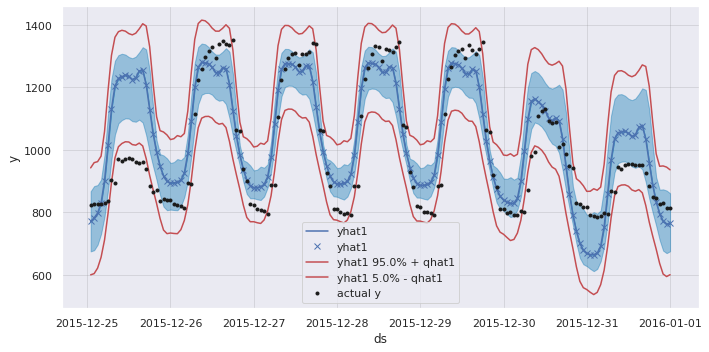

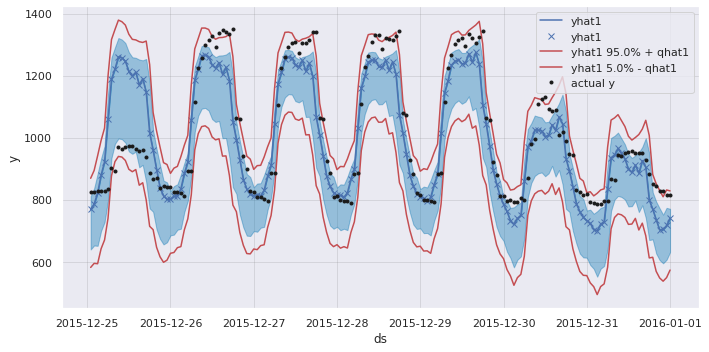

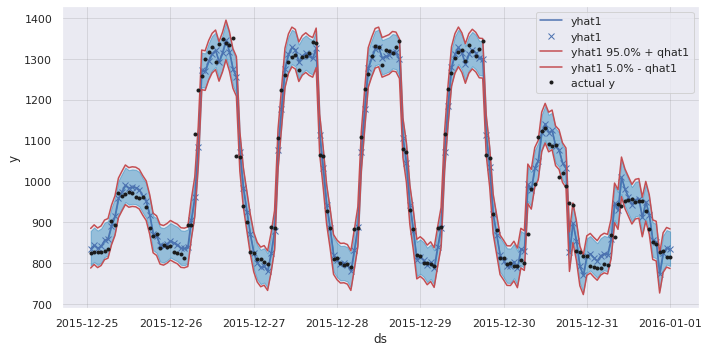

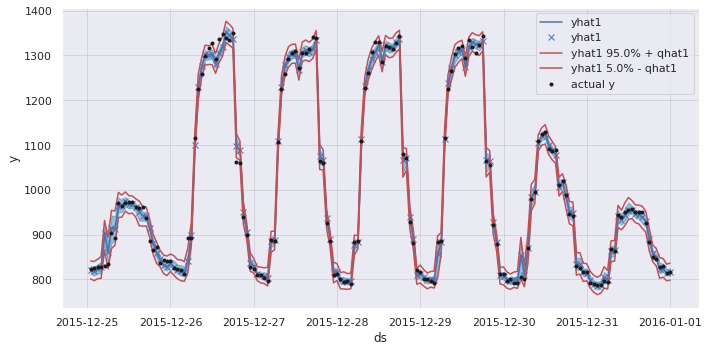

In [48]:
fig1 = m1.highlight_nth_step_ahead_of_each_forecast(1).plot(
    cqr_forecast1[-cutoff:], figsize=figsize, plotting_backend=plotting_backend
)
fig2 = m2.highlight_nth_step_ahead_of_each_forecast(1).plot(
    cqr_forecast2[-cutoff:], figsize=figsize, plotting_backend=plotting_backend
)
fig3 = m3.highlight_nth_step_ahead_of_each_forecast(1).plot(
    cqr_forecast3[-cutoff:], figsize=figsize, plotting_backend=plotting_backend
)
fig4 = m4.highlight_nth_step_ahead_of_each_forecast(1).plot(
    cqr_forecast4[-cutoff:], figsize=figsize, plotting_backend=plotting_backend
)

### Evaluate Performance

- **interval_width**: The average prediction interval, or q_hat multiplied by 2 because it is static or non-adaptive. Also the *efficiency* metric.
- **miscoverage_rate**: The actual miscoverage error rate on the OOS test set. Also the *validity* metric.

For the both metrics, the lower the number, the better the performance.



In [49]:
conformal_methods = ["naive", "cqr"]
eval_df = pd.DataFrame(columns=pd.MultiIndex.from_product([conformal_methods, ["interval_width", "miscoverage_rate"]]))
eval_df = eval_df.reset_index().rename(columns={"index": "model"})

Enter in the model names

In [50]:
eval_df["model"] = ["m1", "m2", "m3", "m4"]

Enter in the **interval_width** (*efficiency* metric)

In [51]:
# Naive interval width
naive_iw = [naive_qhat1 * 2, naive_qhat2 * 2, naive_qhat3 * 2, naive_qhat4 * 2]
eval_df["naive", "interval_width"] = naive_iw

In [52]:
# Calculate CQR interval width function
def calc_cqr_iw(fcast_df, qr_lo, qr_hi, qhat):
    qr_lo_mean = fcast_df["yhat1"].mean() - fcast_df[f"yhat1 {qr_lo}%"].mean()
    qr_hi_mean = fcast_df[f"yhat1 {qr_hi}%"].mean() - fcast_df["yhat1"].mean()
    return qr_lo_mean + qr_hi_mean + qhat * 2

In [53]:
# Quantile low/high values in string (%) format
quantile_lo_str = str(quantile_lo * 100)
quantile_hi_str = str(quantile_hi * 100)

In [54]:
# CQR interval width
cqr_iw1 = calc_cqr_iw(cqr_forecast1, quantile_lo_str, quantile_hi_str, cqr_qhat1)
cqr_iw2 = calc_cqr_iw(cqr_forecast2, quantile_lo_str, quantile_hi_str, cqr_qhat2)
cqr_iw3 = calc_cqr_iw(cqr_forecast3, quantile_lo_str, quantile_hi_str, cqr_qhat3)
cqr_iw4 = calc_cqr_iw(cqr_forecast4, quantile_lo_str, quantile_hi_str, cqr_qhat4)

cqr_iw = [cqr_iw1, cqr_iw2, cqr_iw3, cqr_iw4]
eval_df["cqr", "interval_width"] = cqr_iw

Enter in the **miscoverage rate** (*validity* metric)

In [55]:
# Calculate Naive miscoverage rate function
def calc_naive_mr(fcast_df):
    n_covered = fcast_df.apply(lambda row: bool(row["yhat1 - qhat1"] <= row["y"] <= row["yhat1 + qhat1"]), axis=1)
    coverage_rate = n_covered.sum() / len(fcast_df)
    return 1 - coverage_rate

In [56]:
# Naive miscoverage rate
naive_mr1 = calc_naive_mr(naive_forecast1)
naive_mr2 = calc_naive_mr(naive_forecast2)
naive_mr3 = calc_naive_mr(naive_forecast3)
naive_mr4 = calc_naive_mr(naive_forecast4)

naive_mr = [naive_mr1, naive_mr2, naive_mr3, naive_mr4]
eval_df["naive", "miscoverage_rate"] = naive_mr

In [57]:
# Calculate CQR and CQR Advanced miscoverage rate function
def calc_cqr_mr(fcast_df, qr_lo, qr_hi):
    n_covered = fcast_df.apply(
        lambda row: bool(row[f"yhat1 {qr_lo}% - qhat1"] <= row["y"] <= row[f"yhat1 {qr_hi}% + qhat1"]), axis=1
    )
    coverage_rate = n_covered.sum() / len(fcast_df)
    return 1 - coverage_rate

In [58]:
# CQR miscoverage rate
cqr_mr1 = calc_cqr_mr(cqr_forecast1, quantile_lo_str, quantile_hi_str)
cqr_mr2 = calc_cqr_mr(cqr_forecast2, quantile_lo_str, quantile_hi_str)
cqr_mr3 = calc_cqr_mr(cqr_forecast3, quantile_lo_str, quantile_hi_str)
cqr_mr4 = calc_cqr_mr(cqr_forecast4, quantile_lo_str, quantile_hi_str)

cqr_mr = [cqr_mr1, cqr_mr2, cqr_mr3, cqr_mr4]
eval_df["cqr", "miscoverage_rate"] = cqr_mr

Show evaluation dataframe

In [59]:
eval_df

model          naive                             cqr                 
        interval_width miscoverage_rate interval_width miscoverage_rate
0    m1     321.510601         0.111579     304.167136         0.111579
1    m2     259.384603         0.115789     309.292674         0.126316
2    m3      98.110261         0.090526      97.042411         0.092632
3    m4      43.317302         0.077895      44.818693         0.071579

**Summary**:

- The more complex the model m1->m4, the more accurate it is, hence the lower *interval width* and *miscoverage rate* metrics. The weaker models m1 and m2 have *miscoverage rate* above *alpha* of 0.1 while the stronger NN models m3 and m4 have *miscoverage rate* below *alpha*.
- For default model m1, CQR outputs narrower prediction *interval width* than Naive while maintaining the same *miscoverage rate*.
- However, for biased seasonality model m2,the Naive method has a narrower prediction *interval width* with a slightly better *miscoverage rate* than CQR.
- For complex m3 and m4 models, Naive and CQR methods have comparable *interval_width* and *miscoverage rate*. More testing needs to be done in order to determine which method is preferable to the other under which circumstances.